<a href="https://colab.research.google.com/github/wylhtydtm/Nematode-project/blob/master/JointRecurrencePlot_formultivariatetimeseries_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import tables
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import time
import copy

In [ ]:
!pip install pyts

In [ ]:
import matplotlib.pyplot as plt
from pyts.multivariate.image import JointRecurrencePlot

In [ ]:
class timeseries_dataset(Dataset):

    def __init__(self, hdf5_filename, which_set='train', transform=None):

        self.fname = hdf5_filename
        self.set_name = which_set
        # get labels info
        with tables.File(self.fname, 'r') as fid:
            tmp = pd.DataFrame.from_records(
                fid.get_node('/'+self.set_name)['labels'].read())
        self.label_info = tmp[['imaging_plate_drug_concentration', 'MOA_group', 'ts_id']]
        # any transform?
        self.transform = transform

    def __len__(self):
        return len(self.label_info)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        # I could just use index because ts_id is the same as the index of label_info, but just in case of shuffling...
        label_info = self.label_info.iloc[index]
        ts_id = label_info['ts_id'].astype(int)
        # read data from disk
        with tables.File(self.fname, 'r') as fid:
          timeseries_data = fid.get_node(
                '/' + self.set_name + '/tw_data')[ts_id,:,:].copy()

        if self.transform:  # if any transforms were given to initialiser
            #ts = ts.reshape((8,876),order='A') 
            ts= timeseries_data.T 
            ts = self.transform(ts)
            jrp = JointRecurrencePlot(threshold='point', percentage=50)
            ts = jrp.fit_transform(ts)
          
        # read labels too
        labels = label_info['MOA_group']
        labels = np.array(labels, dtype=np.float32).reshape(-1, 1)
        #lb = preprocessing.LabelBinarizer()
         #labels = lb.fit_transform(labels)
        labels = torch.from_numpy(labels)

        #read the drug concentration
        #concentration = label_info['imaging_plate_drug_concentration']
        #concentration = np.array(concentration, dtype=np.float32).reshape(-1, 1)
        #concentration = torch.from_numpy(concentration)

        return ts, labels

In [ ]:
 hd = Path('/content/drive/My Drive')
 fname = hd / 'Timeseries_0608_set.hdf'
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 80
tw_transform= transforms.ToTensor()

In [ ]:
train_data = timeseries_dataset(fname, which_set='train',transform= tw_transform)
val_data = timeseries_dataset(fname, which_set='val', transform= tw_transform)

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, num_workers=0)
    

In [ ]:
jrp = JointRecurrencePlot(threshold='point', percentage=50)

In [ ]:
images, labels= next(iter(train_loader)) 
images.shape


In [ ]:
images[2][0]

In [ ]:
X_jrp = jrp.fit_transform(images)
X_jrp.shape


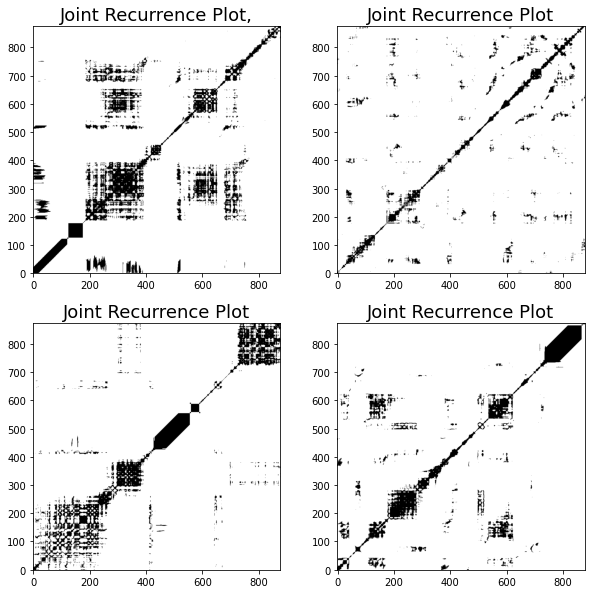

tensor([[6.]])


In [ ]:
# Show the results for the first time series
plt.figure(figsize=(10, 10))
plt.tight_layout()

plt.subplot(221),plt.imshow(X_jrp[0], cmap='binary', origin='lower'),plt.title('Joint Recurrence Plot,', fontsize=18)
plt.subplot(222), plt.imshow(X_jrp[1], cmap='binary', origin='lower'),plt.title('Joint Recurrence Plot', fontsize=18)
plt.subplot(223),plt.imshow(X_jrp[2], cmap='binary', origin='lower'),plt.title('Joint Recurrence Plot', fontsize=18)
plt.subplot(224),plt.imshow(X_jrp[3], cmap='binary', origin='lower'),plt.title('Joint Recurrence Plot', fontsize=18)


plt.show()
print(labels[0])

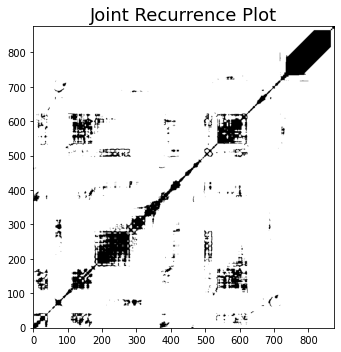

tensor([[13.]])


In [ ]:
# Show the results for the first time series
plt.figure(figsize=(5, 5))
plt.imshow(X_jrp[3], cmap='binary', origin='lower')
plt.title('Joint Recurrence Plot', fontsize=18)
plt.tight_layout()
plt.show()

print(labels[3])

In [ ]:
# Show the results for the first time series
plt.figure(figsize=(5, 5))
plt.imshow(images[2][0], cmap='binary', origin='lower')
plt.title('Joint Recurrence Plot', fontsize=18)
plt.tight_layout()
plt.show()

print(labels[2])

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(), # activation layer
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),# conv layer taking the output of the previous layer
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
                
        self.drop_out = nn.Dropout2d(0.5)
        self.fc_layers =nn.Sequential(nn.Linear(430592, 12))# define fully connected layer
    
    def forward(self, x):
        x = self.conv_layers(x) # pass input through conv layers
        x = self.drop_out(x)  
        x = x.view(x.shape[0], -1) # flatten output for fully connected layer, batchize,-1 do whatever it needs to be 
        x = self.fc_layers(x)# pass  through fully connected layer
        x = F.softmax(x, dim=1) #softmax activation function on outputs, get probability disatribution on output, all ouputs add to 1
        return x 

In [ ]:
learning_rate = 0.0001
epochs = 100

cnn = ConvNet().to(device)# to instantiate model
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr= learning_rate)

In [ ]:
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}
dataset_sizes = {'train':len(train_loader.dataset), 'validation':len(val_loader.dataset)}

In [ ]:
def train_model(model, criterion, optimiser, epochs, verbose= True, tag ='Loss/Train'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model = model.float()

    Liveloss= PlotLosses()
    #Iterate through epochs
    for epoch in range(epochs):
        logs = {}
        print('Epoch{}/{}'.format(epoch, epochs-1))
        print('-' * 15)

        
        #Each epoch has a training and validation phase        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
              
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for index, (inputs, labels) in enumerate (dataloaders[phase]):
                inputs,labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1) # flatten
                labels = labels.long()
                inputs = inputs.float()
                prediction = model(inputs) 
                prediction = prediction.view(labels.size(0), -1)  #flatten
                loss = criterion(prediction, labels) #calculate the loss between predicted and ground truth
                optimiser.zero_grad() # zero the paratmeter gradients
                  
                if phase == 'train':
                    if verbose: print('Epoch:', epoch, '\tBatch:', index, '\tLoss', loss.item())
                    loss.backward()  
                    optimiser.step() # backward + optimize only if in training phase

                _, pred = torch.max(prediction, dim= 1)                  
                running_loss += loss.detach() * inputs.size(0) 
                running_corrects += torch.sum(pred == labels.data)

             # calculate average losses fo the entire epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            prefix = ''
            if phase == 'validation':
                prefix = 'val_'
                
            logs[prefix + ' loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
                    
            #Deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

        Liveloss.update(logs)
        Liveloss.send()

    time_elapse = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapse // 60, time_elapse % 60))
    print('Best Val Acc: {}'.format(best_acc)) 
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

In [ ]:
cnn = train_model(cnn, criterion, optimiser, epochs)
